# Accessing Visual Behavior Neuropixels Data

## Tutorial overview

This Jupyter notebook covers the various methods for accessing the Allen Institute Visual Behavior Neuropixels dataset. We will go over how to request data, where it's stored, and what the various files contain. If you're having trouble downloading the data, or you just want to know more about what's going on under the hood, this is a good place to start.

This data release will not have a web interface for browsing through the released data, as with the [two-photon imaging Visual Coding dataset](http://observatory.brain-map.org/visualcoding). Instead, the data must be retrieved through the AllenSDK (Python 3.6+) or via requests sent to the **Amazon Web Services (AWS)** **Simple Storage Service (S3)** bucket (name: [visual-behavior-neuropixels-data](https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data)) for this project.

Functions related to data analysis as well as descriptions of metadata table columns will be covered in other tutorials. For a full list of available tutorials for this project, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html).

## Options for data access

The `VisualBehaviorNeuropixelsProjectCache` object in the AllenSDK is the easiest way to interact with the released data. This object abstracts away the details of on-disk file storage, and delivers the data to you as ready-to-analyze Python objects. The cache will automatically keep track of which files are stored locally, and will download additional files on an as-needed basis. Usually you won't need to worry about the organization of these files, but this tutorial will cover those details in case you want to analyze them without using the AllenSDK (e.g., in Matlab). This tutorial begins with an introduction to this approach.

Another option is to directly download the data using an S3 URL. This should be used if the other options are broken or are not available to you. Instructions for this can be found <a href='#Direct-download-of-data-from-S3'>at the end of this tutorial</a>.

## Using the AllenSDK to retrieve data

Most users will want to access data via the AllenSDK. This requires nothing more than a Python interpreter and some free disk space to store the data locally.

How much data is there? If you want to download the complete dataset (153 NWB files plus 5 metadata csv files), you'll need 524 GB of space.

Before downloading the data, you must decide on a cache directory where you would like downloaded data to be stored. This directory is where the `VisualBehaviorNeuropixelsProjectCache` object will look first when you request a metadata table or a data file.

When you initialize a local cache for the first time, it will create the manifest file at the path that you specify. This file lives one directory up from the rest of the data, so make sure you put it somewhere that has enough space available.

When you need to access the data in subsequent analysis sessions, you should point the `VisualBehaviorNeuropixelsProjectCache` object to an existing cache directory; otherwise, it will try to re-download the data in a new location.

To get started with this approach, first take care of the necessary imports:

We will first install allensdk into your environment by running the appropriate commands below. 

## Install AllenSDK into your local environment

You can install AllenSDK with:

In [1]:
!pip install allensdk

## Install AllenSDK into your notebook environment (good for Google Colab)

You can install AllenSDK into your notebook environment by executing the cell below.

If using Google Colab, click on the RESTART RUNTIME button that appears at the end of the output when this cell is complete,. Note that running this cell will produce a long list of outputs and some error messages. Clicking RESTART RUNTIME at the end will resolve these issues.
You can minimize the cell after you are done to hide the output.

In [2]:
!pip install --upgrade pip
!pip install allensdk

## Import required packages

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

/opt/hostedtoolcache/Python/3.8.17/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your allensdk version is: 2.15.2


Next, we'll specify the directory where you'd like downloaded data to be stored (cache_dir). Remember to choose a location that has plenty of free space available.

In [4]:
# Update this to a valid directory in your filesystem. This is where the data will be stored.
output_dir = "/tmp/vbn_s3_cache"
DOWNLOAD_COMPLETE_DATASET = False

In [6]:
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:413: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. You might want to consider running

VisualBehaviorNeuropixelsProjectCache.construct_local_manifest()

to avoid needlessly downloading duplicates of data files that did not change between data releases. NOTE: running this method will require hashing every data file you have currently downloaded and could be very time consuming.

To avoid this warning in the future, make sure that

/tmp/tmpiqope07i/_downloaded_data.json

is not deleted between instantiations of this cache
  warnings.warn(msg, MissingLocalManifestWarning)
ecephys_sessions.csv: 100%|██████████| 64.7k/64.7k [00:00<00:00, 486kMB/s] 
behavior_sessions.csv: 100%|██████████| 562k/562k [00:00<00:00, 3.81MMB/s] 
units.csv: 100%|██████████| 132M/132M [00:04<00:00, 29.7MMB/s]
probes.csv: 100%|██████████| 130k/130k [00:00<00:00,

Instantiating the cache will have it to download 5 project metadata files:

1. `ecephys_sessions.csv` (64 kB)
2. `behavior_sessions.csv` (531 kB)
3. `units.csv` (130 MB)
4. `probes.csv` (127 kB)
5. `channels.csv` (28 MB)

Each one contains a table of information related to its file name. If you're using the AllenSDK, you won't have to worry about how these files are formatted. Instead, you'll load the relevant data using specific accessor method: `get_ecephys_session_table()`, `get_behavior_session_table()`, `get_probe_table()`, `get_unit_table()` and `get_channel_table()`. These functions return a pandas DataFrame containing a row for each item and a column for each metric.

If you are analyzing data without using the AllenSDK, you can load the data using your CSV file reader of choice. However, please be aware the columns in the original file do not necessarily match what's returned by the AllenSDK, which may combine information from multiple files to produce the final DataFrame.

### Managing versions of the dataset

Over time, updates may be made to the released dataset. These updates will result in new versions of the dataset being available in the S3 bucket. The versions of the dataset are managed through distinct data manifests stored on S3.

**Note:** Some of the cells below may seem a little pointless at first, since there is only one version of the data release as of this writing (June 7, 2022). We are leaving them here for reference so that future users know how to navigate different versions of the data release as they are issued.

#### Discovering manifests

To see all of the manifest files available for this dataset online, run

In [7]:
cache.list_manifest_file_names()

['visual-behavior-neuropixels_project_manifest_v0.1.0.json',
 'visual-behavior-neuropixels_project_manifest_v0.2.0.json',
 'visual-behavior-neuropixels_project_manifest_v0.3.0.json',
 'visual-behavior-neuropixels_project_manifest_v0.4.0.json']

To see the most up-to-date available manifest, run

In [8]:
cache.latest_manifest_file()

'visual-behavior-neuropixels_project_manifest_v0.4.0.json'

To see the name of the most up-to-date manifest that you have already downloaded to your system run (note: this just means that the manifest file has been downloaded; it does not necessarily mean that any data has been downloaded)

In [9]:
cache.latest_downloaded_manifest_file()

'visual-behavior-neuropixels_project_manifest_v0.4.0.json'

You can list all of the manifest files currently downloaded to your system with

In [10]:
cache.list_all_downloaded_manifests()

['visual-behavior-neuropixels_project_manifest_v0.4.0.json']

#### Loading manifests/dataset versions

The `VisualBehaviorNeuropixelsProjectCache` determines which version of the dataset to use by loading one of these manifests. By default, the `VisualBehaviorNeuropixelsProjectCache` loads either

- the most up-to-date available data manifest, if you are instaniating it on an empty `cache_dir`

- the data manifest you were last using, if you are instantiating it on a pre-existing `cache_dir` (in this case, the `VisualBehaviorNeuropixelsProjectCache` will emit a warning if a more up-to-data data manifest exists online letting you know that you can, if you choose, move to the more up-to-date data manifest)

To see the manifest that you currently have loaded, run

In [11]:
cache.current_manifest()

'visual-behavior-neuropixels_project_manifest_v0.4.0.json'

To load a particular data manifest by hand, run (note: because we are intentionally loading an out-of-date manifest, this will emit a warning alerting us to the existence of the most up-to-date manifest)

In [12]:
cache.load_manifest('visual-behavior-neuropixels_project_manifest_v0.2.0.json')

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:466: OutdatedManifestWarning: 

The manifest file you are loading is not the most up to date manifest file available for this dataset. The most up to data manifest file available for this dataset is 

visual-behavior-neuropixels_project_manifest_v0.4.0.json

To see the differences between these manifests,run

VisualBehaviorNeuropixelsProjectCache.compare_manifests('visual-behavior-neuropixels_project_manifest_v0.2.0.json', 'visual-behavior-neuropixels_project_manifest_v0.4.0.json')

To see all of the manifest files currently downloaded onto your local system, run

self.list_all_downloaded_manifests()

If you just want to load the latest manifest, run

self.load_latest_manifest()


  warnings.warn(msg, OutdatedManifestWarning)
ecephys_sessions.csv: 100%|██████████| 63.5k/63.5k [00:00<00:00, 739kMB/s]
behavior_sessions.csv: 100%|██████████| 531k/531k [00:00<00:00, 2.74MMB/s] 
units.csv: 100%|██████████| 132M/132M

In [13]:
cache.current_manifest()

'visual-behavior-neuropixels_project_manifest_v0.2.0.json'

As the earlier warning informed us, we can see the difference between an two versions of the dataset by running

In [14]:
# This cell will not be useful until an updated version of the data release is issued

msg = cache.compare_manifests('visual-behavior-neuropixels_project_manifest_v0.1.0.json',
                              'visual-behavior-neuropixels_project_manifest_v0.2.0.json')
print(msg)

Changes going from
visual-behavior-neuropixels_project_manifest_v0.1.0.json
to
visual-behavior-neuropixels_project_manifest_v0.2.0.json

project_metadata/units.csv changed



The `VisualBehaviorNeuropixelsProjectCache` is smart enough to know that, if a file has not changed between version `A` and version `B` of the dataset, and you have already downloaded the file while version `A` of the manifest was loaded, when you move to version `B`, it does not need to download the data again. It will simply construct a symlink where version `B` of the data should exist on your system, pointing to version `A` of the file.

### Using the AllenSDK to access Visual Behavior Neuropixels metadata

In [15]:
# Load latest manifest
cache.load_latest_manifest()

#### Ecephys sessions table

Let's look at the contents of `ecephys_sessions.csv`:

In [16]:
ecephys_sessions = cache.get_ecephys_session_table()

print(f"Total number of ecephys sessions: {len(ecephys_sessions)}")

ecephys_sessions.head()

Total number of ecephys sessions: 103


,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30.0,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0.0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62.0,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51.0,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1,879,NaN,NaN


The `ecephys_session_table` DataFrame provides a high-level overview for ecephys sessions in the Visual Behavior Neurpoixels dataset. The index column (ecephys_session_id) is a unique ID, which serves as a key for access behavior data for each session. To get additional information about this data table (and other tables) please visit [this example notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_quickstart.html).

Sharp eyed readers may be wondering why the number of behavior session (103) in this table does not match up with the number of NWB files in the data release (153). Some of the sessions being released had obvious abnormalities in either electrophysiological activity or histology. By default `get_ecephys_session_table()` does not return the metadata for these abnormal sessions. To see all 153 sessions, run `get_ecephys_session_table(filter_abnormalities=False)`


#### Behavior sessions table

Let's look at the contents of `behavior_sessions.csv`:

In [17]:
behavior_sessions = cache.get_behavior_session_table()

print(f"Total number of behavior sessions: {len(behavior_sessions)}")

behavior_sessions.head()

Total number of behavior sessions: 3424


,equipment_name,genotype,mouse_id,sex,age_in_days,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ecephys_session_id,date_of_acquisition,session_type,image_set,file_id
behavior_session_id,,,,,,,,,,,,,,
1055198750,NP.1,wt/wt,531237,F,158,45,5,38.0,0,1.055182e+09,2020-10-07 09:40:30.407000+00:00,HABITUATION_5_images_G_handoff_ready_3uL_reward,G,1022
1052162513,NP.1,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,530862,M,143,41,2,29.0,0,1.051331e+09,2020-09-18 10:18:25.503000+00:00,HABITUATION_5_images_G_handoff_ready_3uL_reward,G,1023
1056100734,NP.1,wt/wt,531237,F,163,48,8,41.0,0,1.056090e+09,2020-10-12 12:31:57.133000+00:00,HABITUATION_5_images_G_handoff_ready_3uL_reward,G,1024
1055397049,NP.1,wt/wt,531237,F,159,46,6,39.0,0,1.055387e+09,2020-10-08 10:46:16.623000+00:00,HABITUATION_5_images_G_handoff_ready_3uL_reward,G,1025
1052162543,NP.1,wt/wt,533537,M,128,30,0,23.0,0,1.052096e+09,2020-09-22 10:54:33.351000+00:00,HABITUATION_5_images_G_handoff_ready_5uL_reward,G,1026


This file contains metadata summarizing every behavior session experienced by the mice in this data release. By filtering on the `mouse_id` column, it can be used to reconstruct the history of any given mouse as it passed through our experimental apparatus.

#### Probes table

Let's look at the contents of `probes.csv`:

In [18]:
probes = cache.get_probe_table()

print(f"Total number of probes: {len(probes)}")

probes.head()

Total number of probes: 905


,ecephys_session_id,name,sampling_rate,lfp_sampling_rate,phase,has_lfp_data,unit_count,channel_count,structure_acronyms,file_id
ecephys_probe_id,,,,,,,,,,
1044506933,1044385384,probeB,30000.178402,2500.014867,1.0,True,701,384,"['CA1', 'DG', 'LP', 'POL', 'PoT', 'VISpm', 'ro...",0
1044506934,1044385384,probeC,30000.049852,2500.004154,1.0,True,307,384,"['MB', 'MRN', 'POST', 'SCig', 'VISp', 'root']",1
1044506935,1044385384,probeD,30000.029115,2500.002426,1.0,True,521,384,"['CA1', 'CA3', 'DG', 'LGv', 'MB', 'TH', 'VISl'...",2
1044506936,1044385384,probeE,30000.075851,2500.006321,1.0,True,282,384,"['CA1', 'DG', 'MB', 'MGd', 'MGm', 'MRN', 'SGN'...",3
1044506937,1044385384,probeF,29999.959578,2499.996631,1.0,True,368,384,"['CA1', 'DG', 'LP', 'MRN', 'POL', 'PoT', 'SGN'...",4


This table records metadata for every neuropixels probe encompassed in this data release. Probes are identified by a unique ID (`ecephys_probe_id`). They can be associated with ecephys sessions via the `ecephys_session_id` column.

#### Channels table

Let's look at the contents of `channels.csv`:

In [19]:
channels = cache.get_channel_table()

print(f"Total number of channels: {len(channels)}")

channels.head()

Total number of channels: 347520


,ecephys_probe_id,ecephys_session_id,probe_channel_number,probe_vertical_position,probe_horizontal_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,structure_acronym,unit_count,valid_data
ecephys_channel_id,,,,,,,,,,,
1049365509,1048089911,1047969464,0,20.0,43.0,8445.0,4013.0,6753.0,MRN,0,True
1049365511,1048089911,1047969464,1,20.0,11.0,8443.0,4005.0,6755.0,MRN,5,True
1049365512,1048089911,1047969464,2,40.0,59.0,8441.0,3997.0,6757.0,MRN,0,True
1049365513,1048089911,1047969464,3,40.0,27.0,8439.0,3989.0,6759.0,MRN,5,True
1049365514,1048089911,1047969464,4,60.0,43.0,8438.0,3981.0,6761.0,MRN,7,True


This table records metadata for each individual channel on the neuropixels probes encompassed in this release. Channels are identified by a unique identifier (`ecephys_channel_id`) and can be linked to probes via the `ecephys_probe_id` column and to sessions via the `ecephys_session_id` column.

#### Units table

Let's look at the contents of `units.csv`:

In [20]:
units = cache.get_unit_table()

print(f"Total number of units: {len(units)}")

units.head()

Total number of units: 319013


,ecephys_channel_id,ecephys_probe_id,ecephys_session_id,amplitude_cutoff,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,cumulative_drift,d_prime,structure_acronym,...,valid_data,amplitude,waveform_duration,waveform_halfwidth,PT_ratio,recovery_slope,repolarization_slope,spread,velocity_above,velocity_below
unit_id,,,,,,,,,,,,,,,,,,,,,
1157005856,1157001834,1046469925,1046166369,0.500000,8453.0,3353.0,6719.0,140.32,6.088133,MB,...,True,286.132665,0.151089,0.096147,0.310791,-0.227726,0.961313,20.0,-0.457845,NaN
1157005853,1157001834,1046469925,1046166369,0.323927,8453.0,3353.0,6719.0,239.76,4.635583,MB,...,True,181.418835,0.357119,0.192295,0.531490,-0.150522,0.732741,30.0,2.060302,-2.060302
1157005720,1157001786,1046469925,1046166369,0.044133,8575.0,3842.0,6590.0,263.32,5.691955,MRN,...,True,180.866205,0.521943,0.178559,0.612217,-0.024239,0.539687,80.0,0.000000,0.863364
1157006074,1157001929,1046469925,1046166369,0.000583,8212.0,2477.0,6992.0,154.64,6.049284,NOT,...,True,574.984215,0.343384,0.192295,0.470194,-0.356670,2.258649,40.0,1.373534,0.000000
1157006072,1157001929,1046469925,1046166369,0.500000,8212.0,2477.0,6992.0,242.58,4.745499,NOT,...,True,315.794115,0.329648,0.164824,0.488276,-0.210010,1.320270,70.0,0.412060,0.343384


This table provides metadata on the units identified in this data release. Quoting the [Visual Coding Neuropixels documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)


>Throughout the SDK, we refer to neurons as “units,” because we cannot guarantee that all the spikes assigned to one unit actually originate from a single cell. Unlike in two-photon imaging, where you can visualize each neuron throughout the entire experiment, with electrophysiology we can only “see” a neuron when it fires a spike. If a neuron moves relative to the probe, or if it’s far away from the probe, some of its spikes may get mixed together with those from other neurons. Because of this inherent ambiguity, we provide a variety of quality metrics to allow you to find the right units for your analysis. Even highly contaminated units contain potentially valuable information about brain states, so we didn’t want to leave them out of the dataset. But certain types of analysis require more stringent quality thresholds, to ensure that all of the included units are well isolated from their neighbors.

Units are identified by a unique `unit_id` and can be associated to channels, probes, and sessions via `ecephys_channel_id`, `ecephys_probe_id` and `ecephys_session_id`.

### Using the AllenSDK to access Visual Behavior Neuropixels data

After looking through the metadata for the data release, let's say you want to access information about a specific ecephys session (ecephys_session_id=1052533639)

The following command will download the NWB file associated with a specific `ecephys_session_id` (unless it has been previously downloaded into this cache) and load it into a python object for manipulation and inspection.

**Note:** each NWB file associated with an ecephys esssion is approximately 2GB in size.

In [21]:
ecephys_session = cache.get_ecephys_session(ecephys_session_id=1052533639)

ecephys_session_1052533639.nwb: 100%|██████████| 2.31G/2.31G [01:30<00:00, 25.5MMB/s]


In [22]:
# List methods of the session that can be used to get data
print(ecephys_session.list_data_attributes_and_methods())

['behavior_data_class', 'behavior_session_id', 'eye_tracking', 'eye_tracking_rig_geometry', 'get_channels', 'get_current_source_density', 'get_lfp', 'get_performance_metrics', 'get_probes_obj', 'get_reward_rate', 'get_rolling_performance_df', 'get_units', 'licks', 'mean_waveforms', 'metadata', 'optotagging_table', 'probes', 'raw_running_speed', 'rewards', 'running_speed', 'spike_amplitudes', 'spike_times', 'stimulus_presentations', 'stimulus_templates', 'stimulus_timestamps', 'task_parameters', 'trials']


Let's try viewing one of the visual stimuli presented to the mouse during the behavior session we downloaded:

In [23]:
# Listing the different stimuli templates
ecephys_session.stimulus_templates

,unwarped,warped
image_name,,
im104_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[136, 138, 140, 141, 141, 141, 140, 140, 140,..."
im114_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[193, 190, 192, 194, 190, 182, 175, 173, 174,..."
im083_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[6, 9, 2, 0, 0, 0, 7, 5, 0, 0, 0, 2, 7, 6, 2,..."
im005_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[81, 82, 80, 76, 76, 80, 83, 82, 80, 78, 78, ..."
im087_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[38, 39, 34, 28, 28, 35, 41, 39, 34, 31, 33, ..."
im024_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[19, 21, 15, 8, 8, 17, 23, 22, 15, 11, 14, 19..."
im111_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[53, 55, 50, 44, 45, 51, 56, 56, 52, 49, 50, ..."
im034_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[124, 126, 128, 128, 129, 129, 129, 129, 127,..."


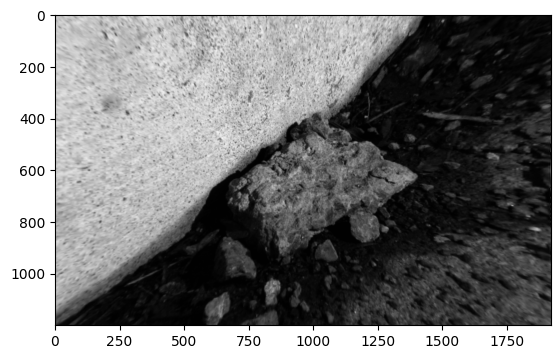

In [24]:
# Visualizing a particular stimulus
plt.imshow(ecephys_session.stimulus_templates['warped']['im104_r'], cmap='gray')

As you can see, the `ecephy_session` object has a lot of attributes and methods that can be used to access underlying data in the NWB file. Most of these will be touched on in other tutorials for [this data release](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels).

Now let's see how to get data for a particular ecephys session:

#### Downloading the complete dataset with AllenSDK

Analyzing one session or experiment at a time is nice, but in some cases you'll want to be able to perform an analysis across the whole dataset. To fill your cache with all available data, you can use a for loop like the one below.

Before running this code, please make sure that you have enough space available in your cache directory. You'll need around 524 GB for to contain all of the NWB files.

In [25]:
# Remove rows from the behavior sessions table which don't correspond to a behavior session NWB file
filtered_ecephys_sessions = ecephys_sessions.dropna(subset=["file_id"])

if DOWNLOAD_COMPLETE_DATASET:
    for ecephys_session_id, _ in filtered_ecephys_sessions.iterrows():
        cache.get_ecephys_session(ecephys_session_id=ecephys_session_id)


## Direct download of data from S3

If you do not wish to obtain data via the AllenSDK `VisualBehaviorNeuropixelsProjectCache` class, this section describes how to directly determine an S3 download link for your file or files of interest.

The S3 bucket that stores all the data for this project's release is: 
<a href='https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com'>https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com</a>

The structure of the S3 bucket looks like:

```
visual-behavior-neuropixels-2022/
│
├── release_notes.txt
│
├── manifests/
│   ├── visual-behavior-neuropixels_project_manifest_v{a.b.c}.json
│   ├── visual-behavior-neuropixels_project_manifest_v{x.y.z}.json
│   ...
│
├── project_metadata/
│   ├── ecephys_sessions.csv
│   ├── behavior_sessions.csv
│   ├── probes.csv
│   ├── channels.csv
│   ├── units.csv
│
└── ecephys_sessions/
    ├── ecephys_session_{abc}.nwb
    ├── ecephys_session_{xyz}.nwb
    ...
```

So if for example, you wanted to download a specific `ecephys_session` you could first download the `ecephys_sessions.csv` with:

<a href='https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/ecephys_sessions.csv'>https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/ecephys_sessions.csv</a> (try clicking me!)

Then using the table, determine the `ecephys_session_id` you are interested in. Let's say we want `ecephys_session_id = 1043752325`, then the appropriate download link would be:

<a href='https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/ecephys_sessions/ecephys_session_1043752325.nwb'>https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/ecephys_sessions/ecephys_session_1043752325.nwb</a>

Below are some simple sample functions that will help you efficiently determine download URL links:

In [26]:
from urllib.parse import urljoin

def get_manifest_url(manifest_version: str) -> str:
    hostname = "https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com"
    object_key = f"visual-behavior-neuropixels/manifests/visual-behavior-neuropixels_project_manifest_v{manifest_version}.json"
    return urljoin(hostname, object_key)

# Example:
print(get_manifest_url("0.1.0"))

https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/manifests/visual-behavior-neuropixels_project_manifest_v0.1.0.json


In [27]:
def get_metadata_url(metadata_table_name: str) -> str:
    hostname = "https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com"
    object_key = f"visual-behavior-neuropixels/project_metadata/{metadata_table_name}.csv"
    return urljoin(hostname, object_key)

# Example:
print(get_metadata_url("behavior_sessions"))

https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/behavior_sessions.csv


In [28]:
def get_behavior_session_url(ecephys_session_id: int) -> str:
    hostname = "https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com"
    object_key = f"visual-behavior-neuropixels/ecephys_sessions/ecephys_session_{ecephys_session_id}.nwb"
    return urljoin(hostname, object_key)

# Example:
print(get_behavior_session_url(1052533639))

https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/ecephys_sessions/ecephys_session_1052533639.nwb


## Downloading previous versions of released data from S3

AllenSDK makes uses of versioned manifest (JSON) files that live in the S3 bucket to keep track of EVERY version of a file for this data release. If a bug/error in the released data is discovered or new data is added to existing NWB files and the updated NWB file is uploaded in the future, a new manifest will be created pointing to the newest version of the file. The existing manifest will continue pointing at the original version allowing reproducibility of analysis results. You can think of each manifest as a snapshot of the state of the S3 bucket when the manifest was created.

This section describes how to download specific versions of a file in the S3 bucket.

### Listing and downloading a specific manifest version for the data release

If you have an AWS account (even a free tier account works) you can log in and access the bucket directly:

<a href='https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?prefix=visual-behavior-neuropixels/manifests/'>https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?prefix=visual-behavior-neuropixels/manifests/</a>

If you don't have or don't want to use an AWS account you can click the following list to get an XML document:

<a href='https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?list-type=2&prefix=visual-behavior-neuropixels/manifests/'>https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?list-type=2&prefix=visual-behavior-neuropixels/manifests/</a>

Which will look like:
```
<ListBucketResult>
  <Name>sfd-cloudcache-test-bucket</Name>
  <Prefix>visual-behavior-neuropixels/manifests/</Prefix>
  <KeyCount>1</KeyCount>
  <MaxKeys>1000</MaxKeys>
  <IsTruncated>false</IsTruncated>
  <Contents>
    <Key>
    visual-behavior-neuropixels/manifests/visual-behavior-neuropixels-2022_project_manifest_v0.1.0.json
    </Key>
    <LastModified>2021-03-22T14:36:31.000Z</LastModified>
    <ETag>"8d10d6dd87234d4e0a1d400908c5013d"</ETag>
    <Size>1730897</Size>
    <StorageClass>STANDARD</StorageClass>
  </Contents>
</ListBucketResult>
```
The XML document is the result of a query which lists all manifests that currently exist for the data release (denoted with `<Key>` `</Key>`). To obtain a specific manifest of interest you just take the `Key` for the manifest you're interested in and append it to the name of the S3 bucket. For example:

<a href='https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?prefix=visual-behavior-neuropixels/manifests/visual-behavior-neuropixels_project_manifest_v0.1.0.json'>https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-neuropixels-data?prefix=visual-behavior-neuropixels/manifests/visual-behavior-neuropixels_project_manifest_v0.1.0.json</a>


### Using a versioned manifest to download a specific data version

Once you've downloaded a manifest, you can use it to obtain download links for the specific version of data files that the manifest tracks. The example function below loads a downloaded manifest and generates download links for *all* the metadata and data files for the specified manifest:

In [29]:
from typing import List
from urllib.parse import urljoin
import json

# The location will differ based on where you downloaded the manifest.json!
my_manifest_location = output_dir / cache.current_manifest()

def generate_all_download_urls_from_manifest(manifest_path: Path) -> List[str]:
    with manifest_path.open('r') as fp:
        manifest = json.load(fp)
    
    download_links = []
    
    # Get download links for specific version of metadata files
    for metadata_file_entry in manifest["metadata_files"].values():
        base_download_url = metadata_file_entry["url"]
        version_query = f"?versionId={metadata_file_entry['version_id']}"
        full_download_url = urljoin(base_download_url, version_query)
        download_links.append(full_download_url)

    # Get download links for specific version of data files
    for data_file_entry in manifest["data_files"].values():
        base_download_url = data_file_entry["url"]
        version_query = f"?versionId={data_file_entry['version_id']}"
        full_download_url = urljoin(base_download_url, version_query)
        download_links.append(full_download_url)    

    return download_links

# Example:
print('\n'.join(generate_all_download_urls_from_manifest(my_manifest_location)))

https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/units.csv?versionId=K.aZm6HBR3BA7B4W3goi5QUTIGy9FfTD
https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/probes.csv?versionId=dBMyMbNLqPSkC94nuDV3z8yGD093YvWO
https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/channels.csv?versionId=WJjTAHnRou9Pzoc5QuNqXfvmHLffJVYm
https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/ecephys_sessions.csv?versionId=NYx9fPisSMFof7QArV6pV9Au8az8CYyy
https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/project_metadata/behavior_sessions.csv?versionId=44Ix7116tPuY83eQighSdAlFVP1LSZUp
https://visual-behavior-neuropixels-data.s3.us-west-2.amazonaws.com/visual-behavior-neuropixels/behavior_ecephys_sessions/1044385384/probe_prob